```{index} single: application; portfolio
```
```{index} single: application; investment
```
```{index} single: solver; cplex
```

# Markowitz portfolio optimization

## Preamble: Install Pyomo and a solver

This cell selects and verifies a global SOLVER for the notebook.

If run on Google Colab, the cell installs Pyomo and ipopt, then sets SOLVER to 
use the ipopt solver. If run elsewhere, it assumes Pyomo and the Mosek solver
have been previously installed and sets SOLVER to use the Mosek solver via the Pyomo 
SolverFactory. It then verifies that SOLVER is available.

In [14]:
import sys
import os

if 'google.colab' in sys.modules:
    !pip install idaes-pse --pre >/dev/null 2>/dev/null
    !idaes get-extensions --to ./bin 
    os.environ['PATH'] += ':bin'
    SOLVER = "ipopt"
    
else:
    SOLVER = "mosek_direct"

import pyomo.environ as pyo
if not pyo.SolverFactory(SOLVER).available():
    print(f"Solver {SOLVER} is not available")

In [15]:
from IPython.display import Markdown, HTML
import numpy as np
import matplotlib.pyplot as plt

## Problem description and model formulation

A canonical stochastic optimization problem is the so-called portfolio selection problem, also known as **Markowitz portfolio optimization**. Assume an investor has an initial capital $C$ that she wants to invest in $n$ possible risky assets, each of them with an unknown return rate $r_i$, $i=1,\dots,n$, or in another risk-free asset with guaranteed return rate $R$. Let $x$ be the vector whose $i$-th component $x_i$ describes the amount invested in asset $i$ and $\tilde{x}$ the amount invested in the risk-free asset. We consider a stochastic model where the return of the $n$ risky assets is then a random vector $r$ with known expected values $\mu = \mathbb E r $ and covariance

$$
    \Sigma = \mathbb{E} [ (r-\mu)(r-\mu)^\top].
$$

The return of the investment $y = R \tilde{x} + r^\top x$ then also becomes a random variable with mean

$$
    \mathbb{E} y = R \tilde{x} + \mathbb{E} r^\top x = R \tilde{x} + \mu^\top x
$$

and variance

$$
    \mathrm{Var}(y) = \mathbb{E}(y-\mathbb{E}y)^2 = x^\top \Sigma x.
$$

The variance of the return of the investment is one possible way to quantify the risk of the investment $x$.

The problem the investor is facing is how to select a portfolio that achieves a good compromise between risk and expected return. More specifically, one could try to maximize the expected return $\mathbb{E} y$ subject to an upper bound on the tolerable risk, obtaining the following optimization problem:

$$
\begin{align*}
    \max \quad  & R \tilde{x} + \mu^\top x \\
    \text{s.t.}\quad
    & \sum_{i=1}^n x_i + \tilde{x}  = C  \\
    & x^\top \Sigma x \leq \gamma \\
    & \tilde{x} \geq 0 \\
    & x_i \geq 0 & \forall \, i=1,\dots,n.
\end{align*}
$$

The first constraint describes the fact that the total amount invested must be equal to the initial capital. The second constraint ensures that the variance of the chosen portfolio is upper bounded by a parameter $\gamma$, which captures the risk the investor is willing to undertake. The last nonnegativity constraint excludes the possibility of short-selling.

One can easily show that the quadratic constraint $x^\top \Sigma x \leq \gamma$ is convex in $x$ due to the fact that $\Sigma$ is positive semidefinite, being a covariance matrix. Therefore, the optimization problem is convex. Let us implement it in Pyomo and solve it.

In [18]:
# Specify the initial capital, the risk threshold, and the guaranteed return rate. 
C = 1
gamma = 1
R = 1.01

# Specify the number of assets, their expected return, and their covariance matrix.
n = 3
mu = np.array([1.2, 1.1, 1.3])
Sigma = np.array([[1.5, 0.5, 2], [0.5, 2, 0], [2, 0, 5]])

# Check that Sigma is semi-definite positive
assert np.all(np.linalg.eigvals(Sigma) >= 0)

# If you want to change the covariance matrix Sigma, ensure you input a semi-definite positive one.
# The easiest way to generate a random covariance matrix is first generating a random m x m matrix A 
# and then taking the matrix A^T A (which is always semi-definite positive)
# m = 3
# A = np.random.rand(m, m)
# Sigma = A.T @ A

def markowitz(gamma, mu, Sigma):
    
    model = pyo.ConcreteModel("Markowitz portfolio optimization")

    model.xtilde = pyo.Var(domain=pyo.NonNegativeReals)
    model.x = pyo.Var(range(n), domain=pyo.NonNegativeReals)

    @model.Objective(sense=pyo.maximize)
    def objective(m):
        return mu @ m.x + R * m.xtilde

    @model.Constraint()
    def bounded_variance(m):
        return (m.x @ (Sigma @ m.x)) <= gamma

    @model.Constraint()
    def total_assets(m):
        return sum(m.x[i] for i in range(n)) + m.xtilde == C

    result = pyo.SolverFactory(SOLVER).solve(model)
    
    return result, model

result, model = markowitz(gamma, mu, Sigma)

display(Markdown(f"**Solver status:** *{result.solver.status}, {result.solver.termination_condition}*"))
display(Markdown(f"**Solution:** $\\tilde x = {model.xtilde.value:.3f}$, $x_1 = {model.x[0].value:.3f}$,  $x_2 = {model.x[1].value:.3f}$,  $x_3 = {model.x[2].value:.3f}$"))
display(Markdown(f"**Maximizes objective value to:** ${model.objective():.2f}$"))

**Solver status:** *ok, optimal*

**Solution:** $\tilde x = 0.158$, $x_1 = 0.561$,  $x_2 = 0.142$,  $x_3 = 0.139$

**Maximizes objective value to:** $1.17$

The next plot shows how the objective function changes as the risk threshold parameter $\gamma$ varies.

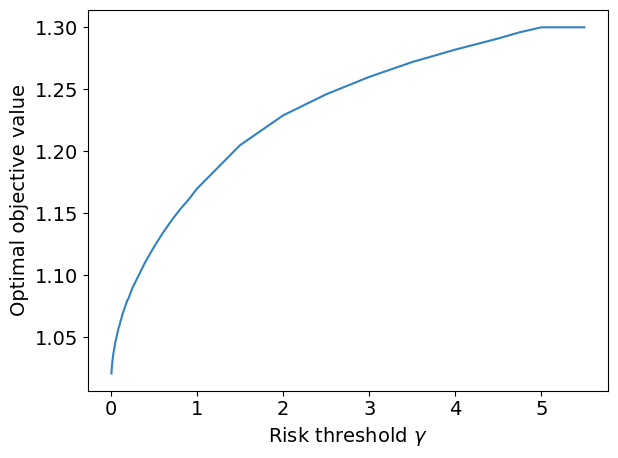

In [31]:
gamma_values = [0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.20, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 4.75, 5, 5.25, 5.5]
objective = []

plt.rcParams.update({'font.size': 14})
for gamma in gamma_values:
    _, model = markowitz(gamma, mu, Sigma)
    objective.append(round(model.objective(),3))

plt.plot(gamma_values, objective, color=plt.cm.tab20c(0))
plt.xlabel(r'Risk threshold $\gamma$')
plt.ylabel('Optimal objective value')
plt.tight_layout()
plt.show()